In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import imageio
import torchvision.transforms as transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load Image & Diffusion Model

In [2]:
class DiffusionForwardProcess:

    r"""

    Forward Process class as described in the
    paper "Denoising Diffusion Probabilistic Models"

    """

    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)

    def add_noise(self, original, noise, t):

        r""" Adds noise to a batch of original images at time-step t.

        :param original: Input Image Tensor
        :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
        :param t: timestep of the forward process of shape -> (B, )

        Note: time-step t may differ for each image inside the batch.

        """

        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]

        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]

        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)

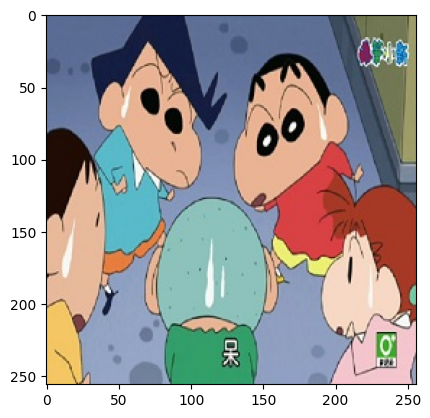

In [3]:
n_iter = 400
images = []
losses = []
to_tensor = tv.transforms.ToTensor()
z = torch.Tensor(np.mgrid[:256, :256]).unsqueeze(0).to(device) / 256

# 加載並轉換圖片
x = Image.open('labi.png').convert('RGB')
plt.imshow(x)
plt.show()
x = to_tensor(x).unsqueeze(0)
sample_img = x
# x, mask = pixel_thanos(x, 0.8)
# mask = mask.to(device)
x = x.to(device)

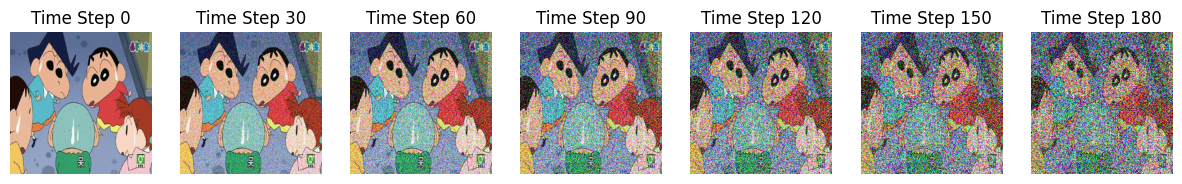

In [4]:
diffusion = DiffusionForwardProcess()
# z = torch.randn(1, 3, 512, 512)
# out = diffusion.add_noise(x, z, torch.tensor([100]))

# 生成隨機噪音
z = torch.randn_like(x)

# 定義不同的時間步長
time_steps = [0, 30, 60, 90, 120, 150, 180]

# 生成不同時間步長上的噪音圖片
noisy_images = []
for t in time_steps:
    noisy_image = diffusion.add_noise(x, z, torch.tensor([t]).to(device))
    noisy_images.append(noisy_image)

# 初始化子圖
fig, axs = plt.subplots(1, len(time_steps), figsize=(15, 5))

# 在不同的時間步長上生成噪音圖片
for i, t in enumerate(time_steps):
    noisy_image = diffusion.add_noise(x, z, torch.tensor([t]).to(device))
    noisy_image = noisy_image[0].cpu().permute(1, 2, 0).numpy()

    # 顯示圖片
    axs[i].imshow(noisy_image)
    axs[i].set_title(f'Time Step {t}')
    axs[i].axis('off')

# 顯示所有圖片
plt.show()

In [5]:
# 反轉圖片顯示順序，並去掉第一張圖片
reversed_noisy_images = noisy_images[-1:0:-1]
reversed_time_steps = time_steps[-1:0:-1]
noisy_images = reversed_noisy_images

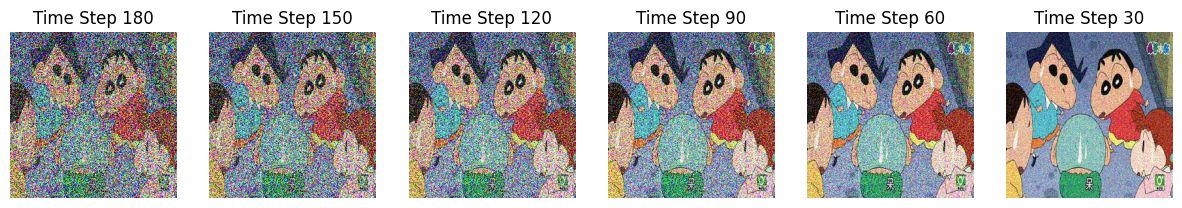

In [6]:
# 顯示反向順序的圖片
fig, axs = plt.subplots(1, len(reversed_noisy_images), figsize=(15, 5))
for i in range(len(reversed_noisy_images)):
    axs[i].imshow(reversed_noisy_images[i][0].cpu().permute(1, 2, 0).numpy())
    axs[i].set_title(f'Time Step {reversed_time_steps[i]}')
    axs[i].axis('off')

plt.show()

### DIP

In [7]:
class Hourglass(nn.Module):
    def __init__(self):
        super(Hourglass, self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(2, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

### PSNR

In [8]:
!pip install scikit-image

In [9]:
import torch
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()
from skimage.metrics import structural_similarity as ssim
def calculate_ssim(img1, img2):
    img1 = img1.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    img2 = img2.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    ssim_value = ssim(img1, img2, multichannel=True)
    return ssim_value

### Training DIP model

<ipython-input-9-d4757617557e>:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(img1, img2, multichannel=True)


Iteration: 400 Loss: 0.2486069
Iteration: 800 Loss: 0.1811042
Iteration: 1200 Loss: 0.1238586
Iteration: 1600 Loss: 0.0761953
Iteration: 2000 Loss: 0.0391094
Iteration: 2400 Loss: 0.0145588


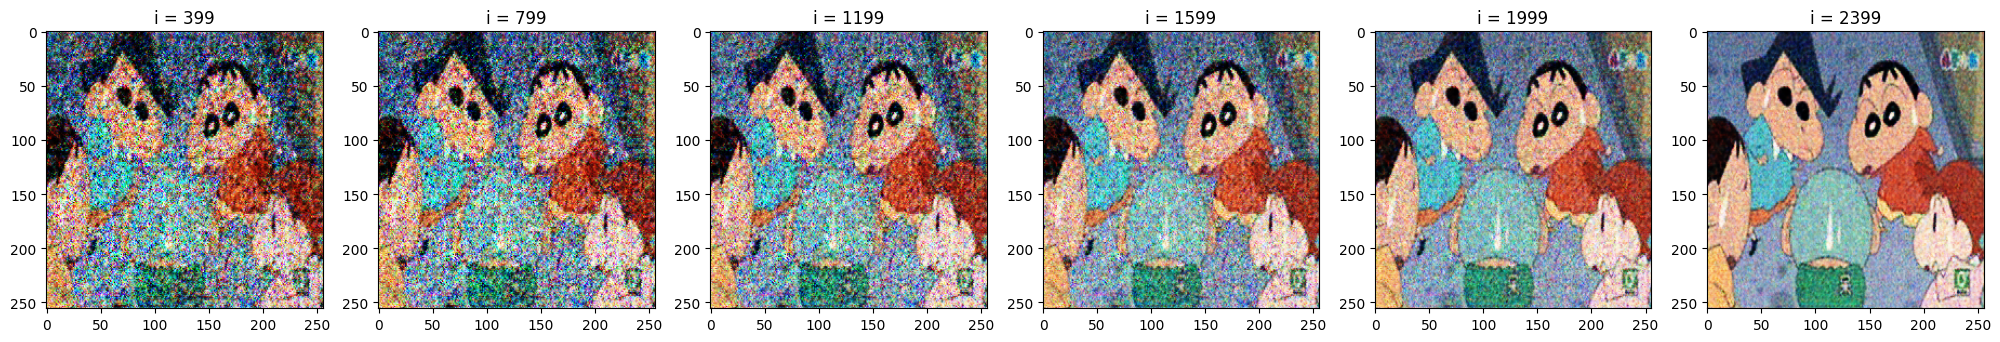

In [10]:
lr = 0.008

# 初始化 Hourglass 模型和優化器
hg_net = Hourglass().to(device)
optimizer = optim.Adam(hg_net.parameters(), lr=lr)
mse_loss = nn.MSELoss()

# 訓練參數
iter_per_stage = 400
total_iter = len(noisy_images) * iter_per_stage
z_input = torch.Tensor(np.mgrid[:256, :256]).unsqueeze(0).to(device) / 256

# 確保 noisy_image 是 PyTorch 張量
# noisy_image = torch.tensor(noisy_image).to(device)

# 訓練模型並顯示過程
fig, axs = plt.subplots(1, len(noisy_images), figsize=(25, 15))
withnoise_psnr_values = []
withnoise_ssim_values = []
withnoise_losses = []

for i in range(total_iter):
    optimizer.zero_grad()
    y = hg_net(z_input)
    # 確保輸出形狀與輸入圖像一致
    # if y.shape != noisy_image[i // iter_per_stage].shape:
    #     y = y[:, :noisy_image[i // iter_per_stage].shape[1], :, :]  # 如果 Hourglass 輸出的通道數超過輸入圖像，則裁剪到輸入圖像的通道數
    # print(y.shape)
    # print((noisy_images[i // iter_per_stage]).shape)
    # print(sample_img.shape)
    # Ensure the output shape is the same as the input image
    # y = y[:, :3, :, :]  # If Hourglass output more than 3 channels, crop to 3 channels
    loss = mse_loss(noisy_images[i//iter_per_stage], y)
    withnoise_psnr_values.append(calculate_psnr(sample_img, y))
    withnoise_ssim_values.append(calculate_ssim(sample_img, y))
    withnoise_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    # 在第一次迭代時顯示圖像
    if i == 0:
        y_img = y[0].cpu().detach().permute(1, 2, 0) * 255
        axs[0].imshow(y_img.numpy().astype(np.uint8))
        axs[0].set_title(f'i = {i}')

    # 每個階段結束時顯示圖像
    if (i + 1) % iter_per_stage == 0:
        y_img = y[0].cpu().detach().permute(1, 2, 0) * 255
        print('Iteration: {} Loss: {:.07f}'.format(i + 1, withnoise_losses[-1]))
        ax_index = int((i+1) // iter_per_stage) - 1
        if ax_index < len(axs):
            axs[ax_index].imshow(y_img.numpy().astype(np.uint8))
            axs[ax_index].set_title(f'i = {i}')

plt.show()

with torch.no_grad():
  out = hg_net(z_input)[0].cpu().detach().permute(1, 2, 0) * 255
  out_img = np.array(out, np.uint8)

# 刪除模型並釋放內存
del hg_net
torch.cuda.empty_cache()
# 刪除優化器
del optimizer

<ipython-input-9-d4757617557e>:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(img1, img2, multichannel=True)


Iteration: 400 Loss: 0.0145588
Iteration: 800 Loss: 0.0145588
Iteration: 1200 Loss: 0.0145588
Iteration: 1600 Loss: 0.0145588
Iteration: 2000 Loss: 0.0145588
Iteration: 2400 Loss: 0.0145588


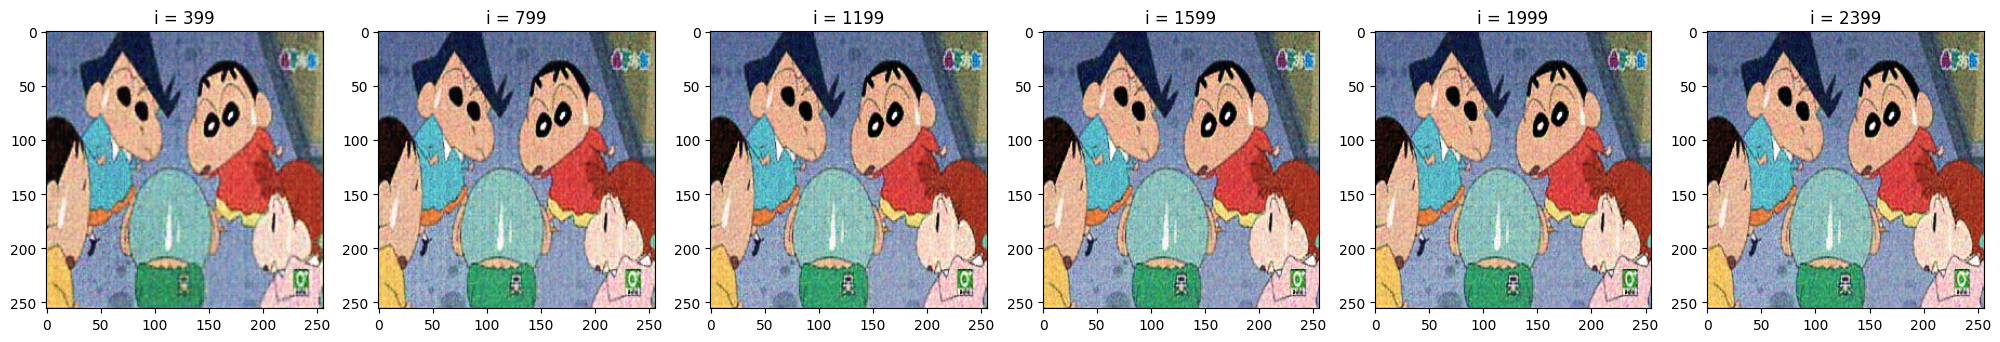

In [11]:
lr = 1e-2

# 創新的 Hourglass 模型和優化器
hg_net = Hourglass().to(device)
optimizer = optim.Adam(hg_net.parameters(), lr=lr)

# 訓練參數
iter_per_stage = 400
total_iter = len(noisy_images) * iter_per_stage
z_input = torch.Tensor(np.mgrid[:256, :256]).unsqueeze(0).to(device) / 256

# 訓練模型並顯示過程
fig, axs = plt.subplots(1, len(noisy_images), figsize=(25, 15))
withoutnoise_psnr_values = []
withoutnoise_ssim_values = []
withoutnoise_losses = []

for i in range(total_iter):
    optimizer.zero_grad()
    y = hg_net(z_input)
    # 確保輸出形狀與輸入圖像一致
    # if y.shape != noisy_image[i // iter_per_stage].shape:
    #     y = y[:, :noisy_image[i // iter_per_stage].shape[1], :, :]  # 如果 Hourglass 輸出的通道數超過輸入圖像，則裁剪到輸入圖像的通道數
    # print(y.shape)
    # print((noisy_images[i // iter_per_stage]).shape)
    # print(sample_img.shape)
    # Ensure the output shape is the same as the input image
    # y = y[:, :3, :, :]  # If Hourglass output more than 3 channels, crop to 3 channels
    loss = mse_loss(noisy_images[-1], y)
    withoutnoise_psnr_values.append(calculate_psnr(sample_img, y))
    withoutnoise_ssim_values.append(calculate_ssim(sample_img, y))
    withoutnoise_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    # 在第一次迭代時顯示圖像
    if i == 0:
        y_img = y[0].cpu().detach().permute(1, 2, 0) * 255
        axs[0].imshow(y_img.numpy().astype(np.uint8))
        axs[0].set_title(f'i = {i}')

    # 每個階段結束時顯示圖像
    if (i + 1) % iter_per_stage == 0:
        y_img = y[0].cpu().detach().permute(1, 2, 0) * 255
        print('Iteration: {} Loss: {:.07f}'.format(i + 1, withnoise_losses[-1]))
        ax_index = int((i+1) // iter_per_stage) - 1
        if ax_index < len(axs):
            axs[ax_index].imshow(y_img.numpy().astype(np.uint8))
            axs[ax_index].set_title(f'i = {i}')

plt.show()

with torch.no_grad():
  out = hg_net(z_input)[0].cpu().detach().permute(1, 2, 0) * 255
  out_img = np.array(out, np.uint8)

# 刪除模型並釋放內存
del hg_net
torch.cuda.empty_cache()
# 刪除優化器
del optimizer

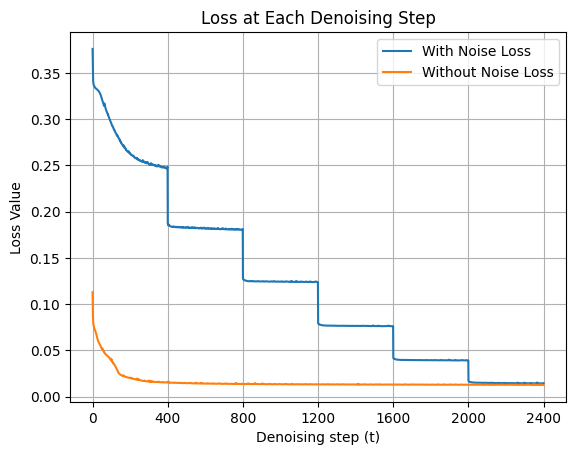

In [12]:
# 繪製 Loss 折線圖
plt.figure()
plt.plot(range(total_iter), withnoise_losses, label='With Noise Loss')
plt.plot(range(total_iter), withoutnoise_losses, label='Without Noise Loss')
plt.xlabel('Denoising step (t)')
plt.ylabel('Loss Value')
plt.title('Loss at Each Denoising Step')
plt.legend()
plt.grid(True)
plt.xticks(range(0, total_iter + 1, iter_per_stage))
plt.show()

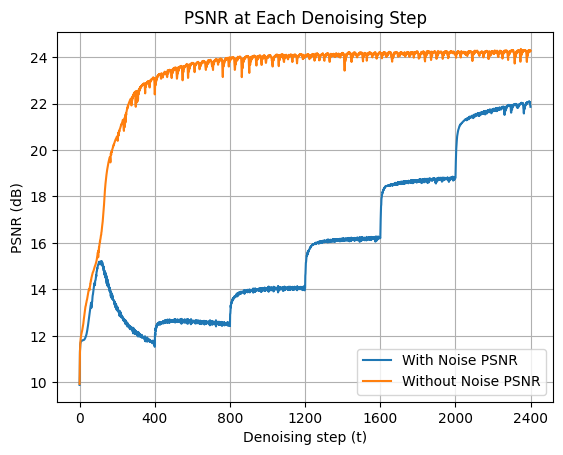

In [13]:
# 繪製 PSNR 折線圖
plt.figure()
plt.plot(range(total_iter), withnoise_psnr_values, label='With Noise PSNR')
plt.plot(range(total_iter), withoutnoise_psnr_values, label='Without Noise PSNR')
plt.xlabel('Denoising step (t)')
plt.ylabel('PSNR (dB)')
plt.title('PSNR at Each Denoising Step')
plt.grid(True)
plt.legend()
plt.xticks(range(0, total_iter + 1, iter_per_stage))
plt.show()

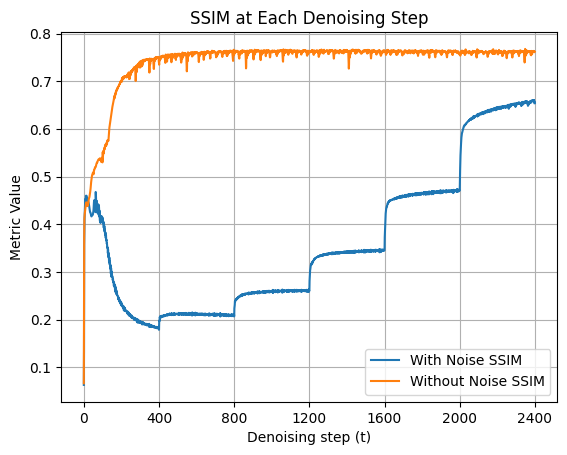

In [14]:
# 繪製 SSIM 折線圖
plt.figure()
plt.plot(range(total_iter), withnoise_ssim_values, label='With Noise SSIM')
plt.plot(range(total_iter), withoutnoise_ssim_values, label='Without Noise SSIM')
plt.xlabel('Denoising step (t)')
plt.ylabel('Metric Value')
plt.title('SSIM at Each Denoising Step')
plt.legend()
plt.grid(True)
plt.xticks(range(0, total_iter + 1, iter_per_stage))

plt.show()